# Building a resnet model using images and xml files

In [1]:
directory = r'C:\Users\paart\DLObj'

In [2]:
import os
os.chdir(directory)

In [5]:
pip install mrcnn


     ---------------------------------------- 51.5/51.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54919 sha256=2fb015a5a24dc4909e7575df6946fa1021063980fdfedef0f5561f64db38ec34
  Stored in directory: c:\users\paart\appdata\local\pip\cache\wheels\88\ab\c3\163055e802b8ca702e365c722848654c4c64a1073764ce6932
Successfully built mrcnn
Note: you may need to restart the kernel to use updated packages.


Train: 62
Test: 16


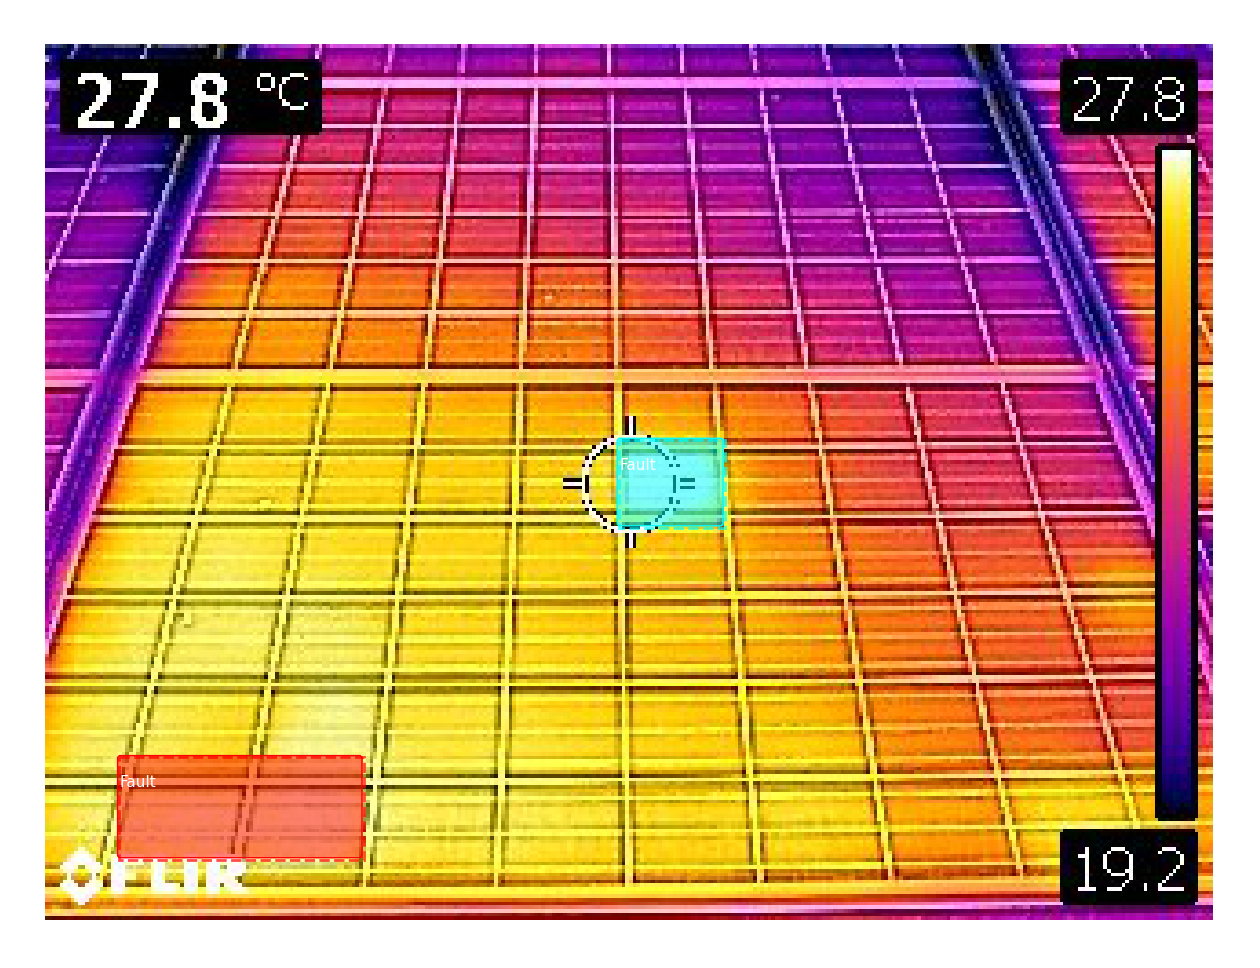


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

TypeError: Could not build a TypeSpec for KerasTensor(type_spec=TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None), name='tf.math.truediv_7/truediv:0', description="created by layer 'tf.math.truediv_7'") of unsupported type <class 'keras.engine.keras_tensor.KerasTensor'>.

In [20]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


# class that defines and loads the kangaroo dataset
class FaultsDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define classes
        self.add_class("dataset", 1, "Fault")
      
        
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
       
             
# find all images
        for filename in listdir(images_dir):
           
# extract image id
            image_id = filename[4:-4]

            if is_train and int(image_id) >= 250:
                continue
# skip all images before 115 if we are building the test/val set
            if not is_train and int(image_id) < 250:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + 'FLIR' + image_id + '.xml'
# add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids = [0])


# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
# load and parse the file
        tree = ElementTree.parse(filename)
# get the root of the document
        root = tree.getroot()
# extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text   #Add label name to the box list
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
# extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

# load the masks for an image
    def load_mask(self, image_id):
# get details of image
        info = self.image_info[image_id]
# define box file location
        path = info['annotation']
        #return info, path
        
        
# load XML
        boxes, w, h = self.extract_boxes(path)
# create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
# create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            
            # box[4] will have the name of the class 
            if (box[4] == 'Fault'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Fault'))

        return masks, asarray(class_ids, dtype='int32')
        

     # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
dataset_dir=r'C:\Users\paart\DLObj'

train_set = FaultsDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = FaultsDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


import random
num=random.randint(0, len(train_set.image_ids))
# define image id
image_id = num
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)



# define a configuration for the model
class FaultsConfig(Config):
    # define the name of the configuration
    NAME = "faults_cfg"
    # number of classes (background +  fault)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 100
    
    
    

# prepare config
config = FaultsConfig()
config.display()

import os
ROOT_DIR = os.path.abspath("./")
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")



# define the model
model = MaskRCNN(mode='training', model_dir="logs", config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')




from matplotlib.patches import Rectangle



In [2]:
import keras.layers as KL

In [9]:
import os
import glob
import random

images_dir =  r'C:\Users\paart\DLObj\rn\images '
annot_dir = r'C:\Users\paart\DLObj\rn\annots '

imagepath_list = glob.glob(os.path.join(images_dir, '*.jpg'))
random.Random(42).shuffle(imagepath_list) #Setting the seed is important to

padding = len(str(len(imagepath_list))) #Number of digits to add for file nu

for n, filepath in enumerate(imagepath_list, 1):
    os.rename(filepath,os.path.join(images_dir, '{:>0{}}.jpg'.format(n,padding)))

annotpath_list = glob.glob(os.path.join(annot_dir, '*.xmL'))
random.Random(42).shuffle(annotpath_list)

for m, filepath in enumerate(annotpath_list, 1):
    os.rename(filepath,os.path.join(annot_dir, '{:>0{}}.xmL'.format(m,padding)))